In [1]:
#!/usr/bin/env python3

import os, sys
sys.path.append('../')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

import sys
sys.path.append('../')

try:
    import mplhep as hep
    hep.style.use("ATLAS")
except:
    pass
delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')



Welcome to JupyROOT 6.30/06


True

## Read events

In [2]:
files = {
         r'$c\tau = 3$ m' : '../pp2chi0chi0J_2_nosmear_scan/Events/run_01/ddmH_mS_500_m2_250_m1_244_dm_90_ctau_3.0_delphes_events.root',
         r'$c\tau = 27$ m' : '../pp2chi0chi0J_2_nosmear_scan/Events/run_02/ddmH_mS_500_m2_250_m1_244_dm_90_ctau_27.0_delphes_events.root',
         r'$c\tau = 108$ m' : '../pp2chi0chi0J_2_nosmear_scan/Events/run_03/ddmH_mS_500_m2_250_m1_244_dm_90_ctau_108.0_delphes_events.root',
         r'$c\tau = 432$ m' : '../pp2chi0chi0J_2_nosmear_scan/Events/run_04/ddmH_mS_500_m2_250_m1_244_dm_90_ctau_432.0_delphes_events.root'
        }

c_light = 2.99792458e8

### Get LLP decay position and time from truth level events (does not include propagation)

In [3]:
rDecaysDict = {}
for label,file in files.items():
    f = ROOT.TFile(file,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    rDecays = []
    triggerFlags = []
    for ievt in range(nevts):
        tree.GetEntry(ievt)

        # Get parton level MET and b-bar angular separation
        llpDec = {}
        llpBoost = {}
        llps = list(tree.llpParticles)
        for illp,llp in enumerate(llps):
            p = np.array([llp.Px,llp.Py,llp.Pz,llp.E])
            beta = np.linalg.norm(p[:3])/p[3]
            llpBoost[illp] = beta
        
        for d in tree.llpDirectDaughters:
            illp = d.M1
            if illp in llpDec:
                continue
            beta = llpBoost[illp]
            x = np.array([d.X,d.Y,d.Z,d.T,beta])
            l = np.linalg.norm(x[:3])*1e-3
            t_readout = x[3]-l/c_light
            t_readout = t_readout*1e9
            x[3] = t_readout
            llpDec[illp] = x
        decs = sorted(llpDec.values(), key = lambda d : d[3])
        rDecays.append(decs)
    f.Close()
    rDecaysDict[label] = rDecays

In [4]:
for label,rDecays in rDecaysDict.items():
    rDecaysDict[label] = np.array(rDecays)

# Plot decay time

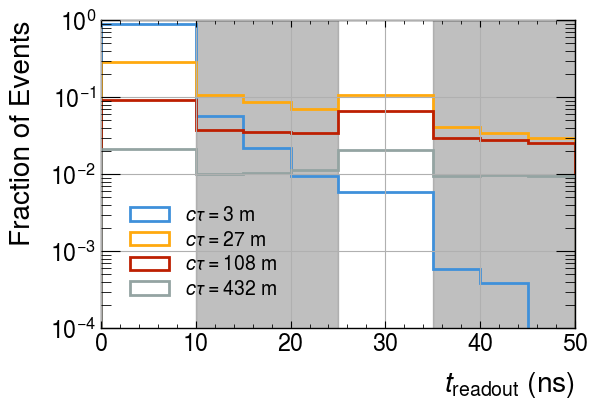

In [5]:
fig = plt.figure(figsize=(6,4))
for label,rDecay in rDecaysDict.items():
    plt.hist(rDecay[:,0,3],bins=[0.,10.,15.,20.,25.,35.,40.,45.,50.],
             histtype='step',
             weights=[1.0/len(rDecay)]*len(rDecay),
             label=label,linewidth=2)
plt.yscale('log')
plt.xlabel(r'$t_{\rm readout}$ (ns)')
plt.ylabel('Fraction of Events')
# plt.vlines(x=[10.,25.,35.],ymin=1e-5,ymax=1,linestyles='dashed',colors='red')
plt.fill_betweenx(y=[1e-5,1],x1=10,x2=25,color='gray',alpha=0.5)
plt.fill_betweenx(y=[1e-5,1],x1=35,x2=50,color='gray',alpha=0.5)
plt.xlim(0.,50)
plt.ylim(1e-4,1)
plt.legend(framealpha=1.0)
plt.grid()
plt.show()

# Plot decay position

### Compute decay position for all LLPs

In [6]:
ptsDict = {}
for label,rDecays in rDecaysDict.items():
    pts = []
    for d in rDecays:
        for dec in d:
            r = np.linalg.norm(dec[:2])*1e-3
            z = dec[2]*1e-3
            pts.append([r,z,dec[3],dec[4]])

    ptsDict[label] = np.array(pts)


### Split LLPs decaying in N-1 and N

In [7]:
ptsDict_ontime = {}
ptsDict_delayed = {}
for label,pts in ptsDict.items():
    ptsDict_ontime[label] = pts[pts[:,2] < 10]
    ptsDict_delayed[label] = pts[(pts[:,2] > 25) & (pts[:,2] < 35)]
    print(f'{label} : decays in N-1 = {len(ptsDict_ontime[label])/len(ptsDict[label]):1.4f}, decays in N = {len(ptsDict_delayed[label])/len(ptsDict[label]):1.4f}')

$c\tau = 3$ m : decays in N-1 = 0.9045, decays in N = 0.0059
$c\tau = 27$ m : decays in N-1 = 0.2856, decays in N = 0.1071
$c\tau = 108$ m : decays in N-1 = 0.0909, decays in N = 0.0653
$c\tau = 432$ m : decays in N-1 = 0.0215, decays in N = 0.0208


In [8]:
def in_hcal(z,rho):

    if 4.3 < abs(z) < 5.0 and rho < 3.5:
        return True
    elif 2.0 < rho < 3.5 and abs(z) < 4.3:
        return True
    else:
        return False

### Plot decays

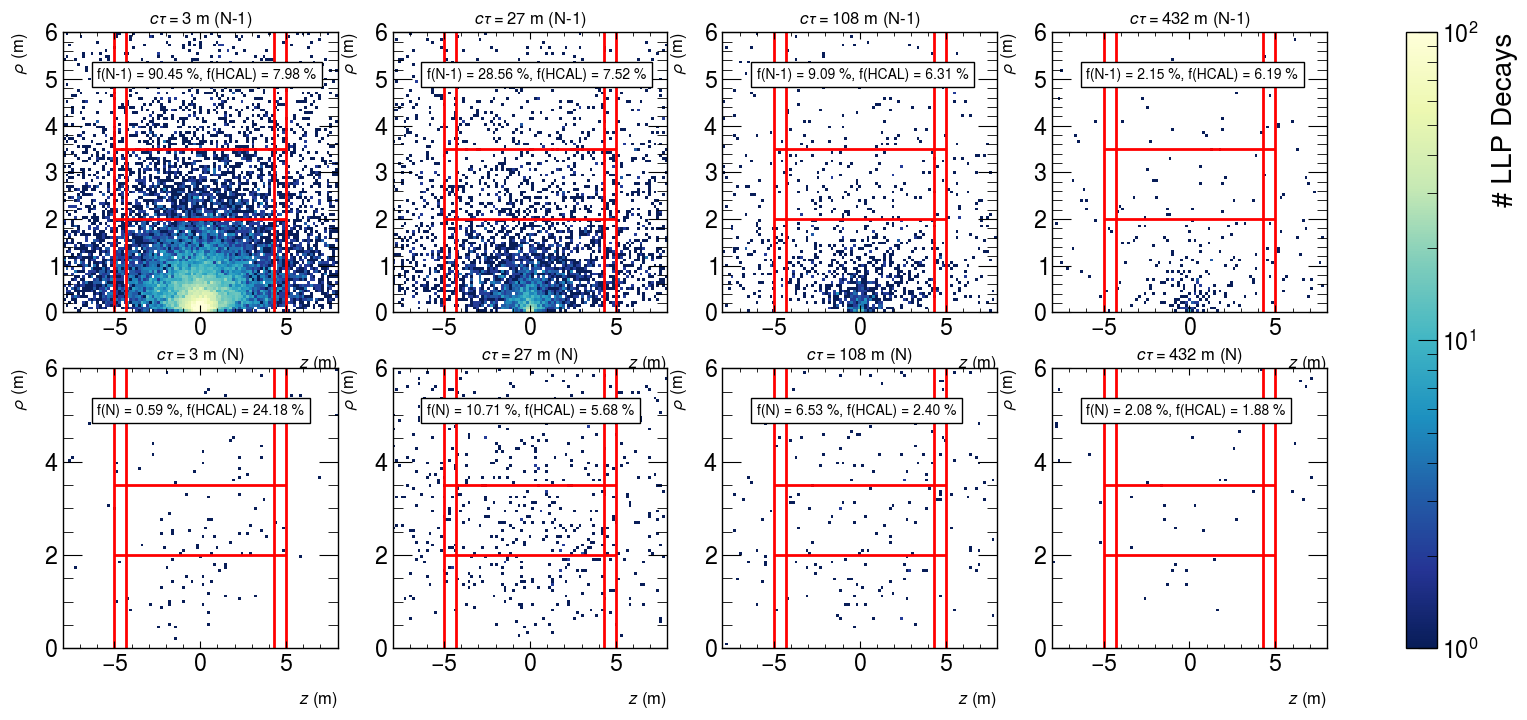

In [9]:

ncols = len(ptsDict)

fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 8))

images = []
for j,label in enumerate(ptsDict.keys()):
    for i,pts in enumerate([ptsDict_ontime[label],ptsDict_delayed[label]]):
        ax = axes[i,j]
        _,_,_,im = ax.hist2d(pts[:,1],pts[:,0],
            bins=[np.linspace(-8,8,100),np.linspace(0.,6.,100)],
            cmap = mpl.colormaps['YlGnBu_r'], 
            norm = mpl.colors.LogNorm(vmin=1.0,vmax=100.))
        if i == 0:
            ax.set_title(f'{label} (N-1)',fontsize=12)
        else:
            ax.set_title(f'{label} (N)',fontsize=12)
        images.append(im)

        nHcal = sum([in_hcal(z=pt[1],rho=pt[0]) for pt in pts])
        # nHcal = (100.0*nHcal)/len(ptsDict[label])
        nHcal = (100.0*nHcal)/len(pts)
        n = 100.0*len(pts)/len(ptsDict[label])
        if i == 0:
            ax.text(-6.,5.,f'f(N-1) = {n:1.2f} %, f(HCAL) = {nHcal:1.2f} %',alpha=1.0,fontsize=10, bbox=dict(facecolor='white', alpha=1.0))
        else:
            ax.text(-6.,5.,f'f(N) = {n:1.2f} %, f(HCAL) = {nHcal:1.2f} %',alpha=1.0,fontsize=10, bbox=dict(facecolor='white', alpha=1.0))

        ax.vlines(x=[4.3,5.0],ymin=0.,ymax=10.,colors='red')
        ax.vlines(x=[-4.3,-5.0],ymin=0.,ymax=10.,colors='red')
        ax.hlines(y=[2.0,3.5],xmin=-5.0,xmax=5.0,colors='red')
        ax.set_xlabel(r'$z$ (m)',fontsize=12)
        ax.set_ylabel(r'$\rho$ (m)',fontsize=12)

fig.colorbar(images[0], ax=axes.ravel().tolist(), orientation='vertical', label='# LLP Decays')        
plt.show()

### Plot Boost

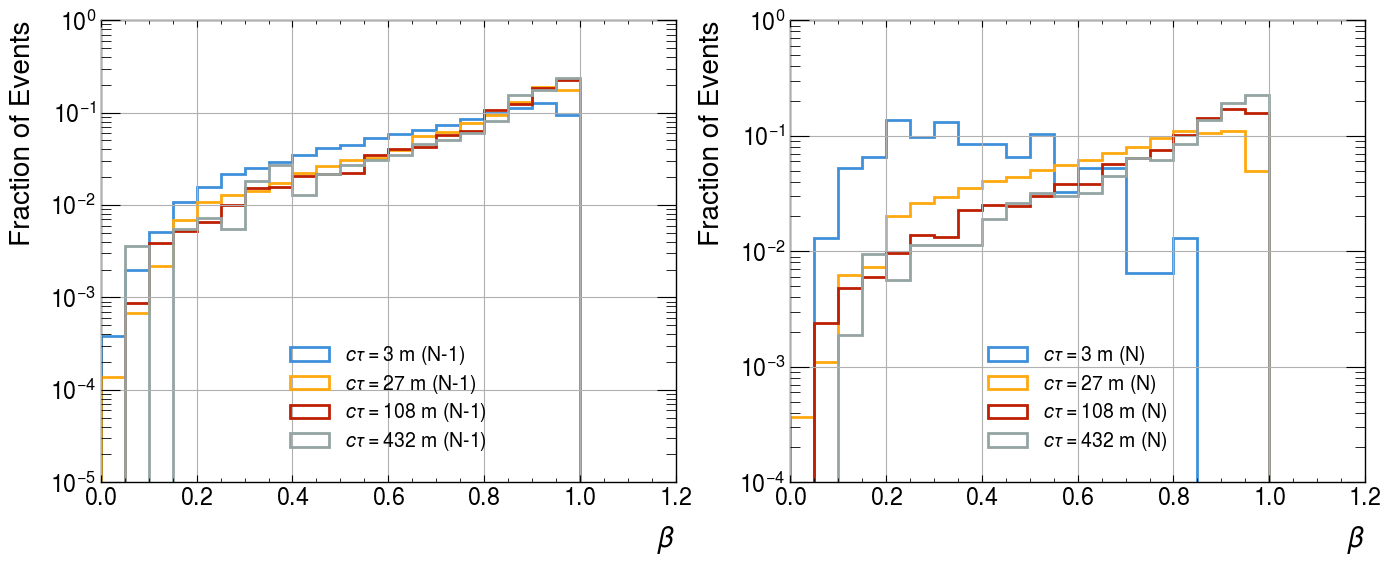

In [10]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4*ncols, 6)) # Example 2x2 grid


for label,pts in ptsDict_ontime.items():
    axes[0].hist(pts[:,3],bins=np.linspace(0.,1.2,25),
             histtype='step',
             weights=[1.0/len(pts)]*len(pts),
             label=f'{label} (N-1)',linewidth=2)
    pts = ptsDict_delayed[label]
    axes[1].hist(pts[:,3],bins=np.linspace(0.,1.2,25),
             histtype='step',
             weights=[1.0/len(pts)]*len(pts),
             label=f'{label} (N)',linewidth=2)
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel('Fraction of Events')
    ax.legend()
    ax.grid()

plt.show()

The above behavior for the small lifetime in N events is due to the requirement that the readout time ($t_r$) is given by:
$$
t_r \sim t_d - c\beta t_d/c = t_d(1-\beta) \sim \gamma \tau_0 (1-\beta)
$$
but since $\gamma = 1/\sqrt{1-\beta^2}$:
$$
t_r \sim \tau_0 \sqrt{\frac{1-\beta}{1+\beta}}
$$
Hence for small proper lifetime we need small $\beta$ to achieve large *readout* times. As a result, decays taking place in the $N$ event record
will correspond to small $\beta$ and therefore result in smaller traveled distance (when compare to scenarios with larger $\tau_0$). This enhances the fraction of $N$-decays within the HCAL.